In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import importlib
import torch
import pandas as pd
import os
import sys
import json
from scipy import stats
from scipy.stats import spearmanr
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from recover.utils.utils import get_tensor_dataset
import reservoir as rdl
from copy import deepcopy
import numpy as np
from tqdm import tqdm
import random

from rdkit import DataStructs

## Tanimoto similiarity

In [2]:
from recover.datasets.drugcomb_matrix_data import DrugCombMatrixOneHiddenDrugSplitTest

data = DrugCombMatrixOneHiddenDrugSplitTest(cell_line='MCF7',
                                 fp_bits=1024,
                                 fp_radius=2).data

Dataset loaded.
4463 drug comb experiments among 149 drugs
	 fingeprints with radius 2 and nbits 1024
	 drug features dimension 1173
	 1 cell-lines
1981 drug comb experiments among 149 drugs


In [3]:
propr_drug_in_trainval = 0.7

# Choose at random a proportion drug_prop of the drugs
all_drug_idxs = list(data.rec_id_to_idx_dict.values())
random.Random(0).shuffle(all_drug_idxs)
trainval_drug_idxs = all_drug_idxs[:int(propr_drug_in_trainval*len(all_drug_idxs))]
hidden_drug_idxs = all_drug_idxs[int(propr_drug_in_trainval * len(all_drug_idxs)):]

In [4]:
def tanimoto_similarity(u, v):
    assert np.logical_or(u == 0, u == 1).all()
    assert np.logical_or(v == 0, v == 1).all()
    
    u2 = u.sum()
    v2 = v.sum()
    
    uv = (u * v).sum()
    
    return uv / (u2 + v2 - uv)

In [5]:
similarity_mat = np.zeros((data.x_drugs.shape[0], data.x_drugs.shape[0]))

for i in range(data.x_drugs.shape[0] - 1):
    for j in range(i+1, data.x_drugs.shape[0]):
        i_j_similarity = tanimoto_similarity(data.x_drugs[i, :1024].numpy(), data.x_drugs[j, :1024].numpy())
        similarity_mat[i, j] = i_j_similarity
        similarity_mat[j, i] = i_j_similarity

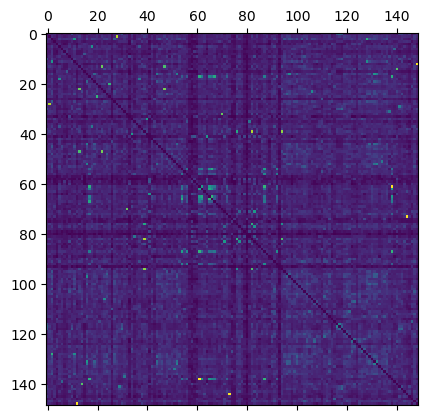

In [6]:
plt.matshow(similarity_mat)
# plt.clim(0,1) 
# plt.colorbar()
plt.show()

In [7]:
similarity_mat[similarity_mat != 0].min()

0.006896551698446274

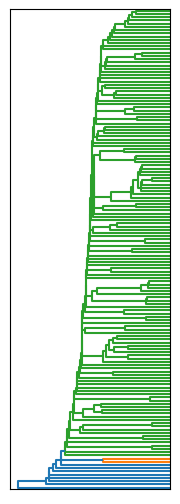

In [8]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

tanimoto_distances = 1/(similarity_mat + 0.001)
for i in range(len(tanimoto_distances)):
    tanimoto_distances[i, i] = 0
                        
condensedD = squareform(tanimoto_distances)

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
Y = sch.linkage(condensedD, method="single")
Z1 = sch.dendrogram(Y, orientation="left")
ax1.set_xticks([])
ax1.set_yticks([])
plt.show()

In [9]:
idx1 = Z1['leaves']

In [10]:
# Reorder indices based on tanimoto hierarchical clustering
trainval_drug_idxs = [idx for idx in Z1['leaves'] if idx in trainval_drug_idxs]
hidden_drug_idxs = [idx for idx in Z1['leaves'] if idx in hidden_drug_idxs]

## Uncertainty matrix

In [11]:
def eval_epoch_extended_output(data, loader, model):
    model.eval()

    epoch_loss = 0
    num_batches = len(loader)

    all_out = []
    all_mean_preds = []
    all_targets = []
    all_combos = []
    all_cell_lines = []

    with torch.no_grad():
        for _, drug_drug_batch in enumerate(loader):
            out = model.forward(data, drug_drug_batch)

            # Save all predictions and targets
            all_out.append(out)
            all_mean_preds.extend(out.mean(dim=1).tolist())
            all_targets.extend(drug_drug_batch[2].tolist())
            all_combos.extend(drug_drug_batch[0].tolist())
            all_cell_lines.extend(drug_drug_batch[1].tolist())

            loss = model.loss(out, drug_drug_batch)
            epoch_loss += loss.item()

        epoch_comb_r_squared = stats.linregress(all_mean_preds, all_targets).rvalue**2
        epoch_spear = spearmanr(all_targets, all_mean_preds).correlation

    summary_dict = {
        "loss_mean": epoch_loss / num_batches,
        "comb_r_squared": epoch_comb_r_squared,
        "spearman": epoch_spear
    }

    print("Testing", summary_dict, '\n')

    all_out = torch.cat(all_out)

    return summary_dict, {"all_out": all_out, "all_combos": all_combos, "all_targets": all_targets, 
                          "all_cell_lines": all_cell_lines, "data": data}

In [12]:
#####################################
# Methods to get different types of loaders
#####################################


def get_regular_valid_loader(trainer):
    return trainer.valid_loader

def get_test_loader(trainer):
    test_dataset = get_tensor_dataset(trainer.data, trainer.test_idxs)
    test_loader = DataLoader(test_dataset, batch_size=128)
    
    return test_loader


#####################################
# Iterator over trainers for a given config
#####################################


def trainer_iterator(config_file, path_to_conf):
    configuration = importlib.import_module("recover.config." + config_file).configuration

    # Loop over all runs for this configuration
    for run_dir in tqdm(os.listdir(os.path.join(path_to_conf, config_file))):
        print(run_dir)
        if run_dir.startswith('BasicTrainer'):

            this_run_results = {}

            # Load params for that run
            with open(os.path.join(path_to_conf, config_file, run_dir, 'params.json')) as f:
                params = json.load(f)

            # Load configuration (can contain grid_search args)
            this_run_config = deepcopy(configuration)

            # Replace grid_search args by the actual parameter for that run
            for key in this_run_config['trainer_config']:
                if type(this_run_config['trainer_config'][key]) is dict \
                and 'grid_search' in this_run_config['trainer_config'][key].keys():
                    
                    # If grid search over python classes, we need to load them
                    if type(params[key]) is str and params[key].startswith('<class'):
                        class_to_load = params[key]
                        class_to_load = class_to_load.split("'")[1]
                        class_to_load = class_to_load.rpartition('.')
                        path_to_class = class_to_load[0]
                        class_to_load_name = class_to_load[-1]
                        params[key] = getattr(importlib.import_module(path_to_class), 
                                              class_to_load_name)
                    this_run_config['trainer_config'][key] = params[key]
                    this_run_results[key] = params[key]

            # Load trainer
            trainer = this_run_config["trainer"](this_run_config["trainer_config"])

            # Find the checkpoint corresponding to the best epoch (always two checkpoints, 
            # corresponding to best and last epochs)
            cpt = 0
            checkpoint = None
            for dir_check in os.listdir(os.path.join(path_to_conf, config_file, run_dir)):
                if dir_check.startswith('checkpoint'):
                    cpt += 1
                    if checkpoint is None:
                        checkpoint = dir_check
                    else:
                        if int(dir_check.split('_')[-1]) < int(checkpoint.split('_')[-1]):
                            checkpoint = dir_check
                            
            if cpt == 2:
                # Only yield trainer if 2 checkpoints have been saved (corresponding to best and last epochs)

                # Load model
                trainer.model.load_state_dict(torch.load(path_to_conf + config_file + "/" + 
                                                 run_dir + "/" + checkpoint + "/model.pth",
                                                 map_location=torch.device('cpu')))
                print("Loaded model from", run_dir, checkpoint)
                
                yield trainer

#####################################
# Main evaluation method
#####################################


def evaluate_config(config_file, path_to_conf, get_eval_loader=get_regular_valid_loader):
    all_results = pd.DataFrame()

    for trainer in trainer_iterator(config_file, path_to_conf):
        
        this_run_results = {}

        # Evaluate
        eval_metrics, dict_output = eval_epoch_extended_output(trainer.data, get_eval_loader(trainer), trainer.model)
        
        # Create dataframe for this run
        print("this run results", this_run_results)
        print("eval metrics", eval_metrics)

        this_run_results = {**this_run_results, **eval_metrics, **dict_output}
        for key in this_run_results.keys():
            this_run_results[key] = [this_run_results[key]]

        this_run_df = pd.DataFrame.from_dict(this_run_results)

        all_results = all_results.append(this_run_df)

    all_results.reset_index()
        
    return all_results
        

In [13]:
from recover.datasets.drugcomb_matrix_data import DrugCombMatrixOneHiddenDrugSplitTest, \
DrugCombMatrixOneHiddenDrugSplitTestExtension, DrugCombMatrixOneHiddenDrugSplitTrain

def get_one_hidden_drug_split_test_loader(trainer):
    
    ohd_split_data = DrugCombMatrixOneHiddenDrugSplitTest(cell_line='MCF7',
                                     fp_bits=1024,
                                     fp_radius=2)
    ohd_split_data.data.ddi_edge_response = ohd_split_data.data.ddi_edge_bliss_max
    
    test_idxs = range(len(ohd_split_data.data.ddi_edge_response))
    
    test_dataset = get_tensor_dataset(ohd_split_data.data, test_idxs)
    test_loader = DataLoader(test_dataset, batch_size=128)
    
    return test_loader

def get_one_hidden_drug_split_trainval_loader(trainer):
    
    ohd_split_data = DrugCombMatrixOneHiddenDrugSplitTrain(cell_line='MCF7',
                                     fp_bits=1024,
                                     fp_radius=2)
    ohd_split_data.data.ddi_edge_response = ohd_split_data.data.ddi_edge_bliss_max
    
    trainval_idxs = range(len(ohd_split_data.data.ddi_edge_response))
    
    trainval_dataset = get_tensor_dataset(ohd_split_data.data, trainval_idxs)
    trainval_loader = DataLoader(trainval_dataset, batch_size=128)
    
    return trainval_loader

def get_one_hidden_drug_split_test_extension_loader(trainer):
    
    ohd_split_data = DrugCombMatrixOneHiddenDrugSplitTestExtension(cell_line='MCF7',
                                     fp_bits=1024,
                                     fp_radius=2)
    ohd_split_data.data.ddi_edge_response = ohd_split_data.data.ddi_edge_bliss_max
    
    test_idxs = range(len(ohd_split_data.data.ddi_edge_response))
    
    test_dataset = get_tensor_dataset(ohd_split_data.data, test_idxs)
    test_loader = DataLoader(test_dataset, batch_size=128)
    
    return test_loader

In [14]:
old_stdout = sys.stdout # backup current stdout
sys.stdout = open(os.devnull, "w")

all_results = evaluate_config(config_file="uncertainty_estimate_analysis_ens_20", 
             path_to_conf="/Users/paul/PycharmProjects/NewReservoir/"
                              "Recover/RayLogs/",
             get_eval_loader=get_one_hidden_drug_split_test_loader)

sys.stdout = old_stdout # reset old stdout

print("R2", round(all_results['comb_r_squared'].mean(), 3), "\pm", 
      round(all_results['comb_r_squared'].std(),3))
print('spearman', round(all_results['spearman'].mean(), 3), "\pm", 
      round(all_results['spearman'].std(), 3))

  0%|                                                                                                                                                 | 0/5 [00:00<?, ?it/s]/var/folders/k3/yv9hq08j1vvbkzfmhdr7b05w0000gn/T/ipykernel_1338/1880582301.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_results = all_results.append(this_run_df)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.62s/it]

R2 0.193 \pm 0.005
spearman 0.313 \pm 0.006


In [15]:
all_results = all_results.reset_index()

In [16]:
all_results

,index,loss_mean,comb_r_squared,spearman,all_out,all_combos,all_targets,all_cell_lines,data
0,0,65.146531,0.190074,0.310938,"[[tensor(9.2252), tensor(9.4869), tensor(9.478...","[[51, 27], [27, 92], [11, 27], [1, 27], [27, 7...","[11.809586524963379, 3.14078426361084, 19.7604...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...",<recover.datasets.drugcomb_matrix_data.Data ob...
1,0,64.179792,0.199134,0.319717,"[[tensor(10.8019), tensor(11.3668), tensor(11....","[[51, 27], [27, 92], [11, 27], [1, 27], [27, 7...","[11.809586524963379, 3.14078426361084, 19.7604...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...",<recover.datasets.drugcomb_matrix_data.Data ob...
2,0,64.945637,0.189892,0.308310,"[[tensor(9.4447), tensor(9.2778), tensor(9.731...","[[51, 27], [27, 92], [11, 27], [1, 27], [27, 7...","[11.809586524963379, 3.14078426361084, 19.7604...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...",<recover.datasets.drugcomb_matrix_data.Data ob...


In [17]:
predictions = all_results.loc[0]["all_out"]

In [18]:
data = all_results.loc[0]["data"]

In [19]:
combos = all_results.loc[0]["all_combos"]

In [20]:
cell_lines = all_results.loc[0]["all_cell_lines"]

In [21]:
np.unique(cell_lines)

array([18])

In [22]:
data.x_drugs

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [23]:
true_index_to_plot_index = {**{trainval_drug_idxs[i]: i for i in range(len(trainval_drug_idxs))},
                    **{hidden_drug_idxs[i]: i + len(trainval_drug_idxs) for i in range(len(hidden_drug_idxs))}}

In [24]:
uncertainties = {tuple(combos[i]): float(predictions.std(dim=1)[i]) for i in range(len(combos))}

In [25]:
max(uncertainties.values())

1.2883113622665405

In [26]:
plot_mat = - np.ones((data.x_drugs.shape[0], data.x_drugs.shape[0]))

In [27]:
for k, v in uncertainties.items():
    plot_mat[true_index_to_plot_index[k[0]], true_index_to_plot_index[k[1]]] = v
    plot_mat[true_index_to_plot_index[k[1]], true_index_to_plot_index[k[0]]] = v

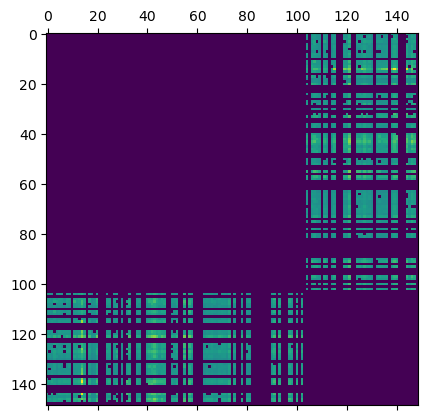

In [28]:
plt.matshow(plot_mat)
plt.show()

In [29]:
old_stdout = sys.stdout # backup current stdout
sys.stdout = open(os.devnull, "w")

all_results = evaluate_config(config_file="uncertainty_estimate_analysis_ens_20", 
             path_to_conf="/Users/paul/PycharmProjects/NewReservoir/"
                              "Recover/RayLogs/",
             get_eval_loader=get_one_hidden_drug_split_test_extension_loader)

sys.stdout = old_stdout # reset old stdout

print("R2", round(all_results['comb_r_squared'].mean(), 3), "\pm", 
      round(all_results['comb_r_squared'].std(),3))
print('spearman', round(all_results['spearman'].mean(), 3), "\pm", 
      round(all_results['spearman'].std(), 3))

  0%|                                                                                                                                                 | 0/5 [00:00<?, ?it/s]/var/folders/k3/yv9hq08j1vvbkzfmhdr7b05w0000gn/T/ipykernel_1338/1880582301.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_results = all_results.append(this_run_df)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.16s/it]

R2 0.066 \pm 0.001
spearman 0.183 \pm 0.001


In [30]:
all_results = all_results.reset_index()

In [31]:
combos = all_results.loc[0]["all_combos"]

In [32]:
predictions = all_results.loc[0]["all_out"]

In [33]:
uncertainties = {tuple(combos[i]): float(predictions.std(dim=1)[i]) for i in range(len(combos))}

In [34]:
for k, v in uncertainties.items():
    plot_mat[true_index_to_plot_index[k[0]], true_index_to_plot_index[k[1]]] = v
    plot_mat[true_index_to_plot_index[k[1]], true_index_to_plot_index[k[0]]] = v

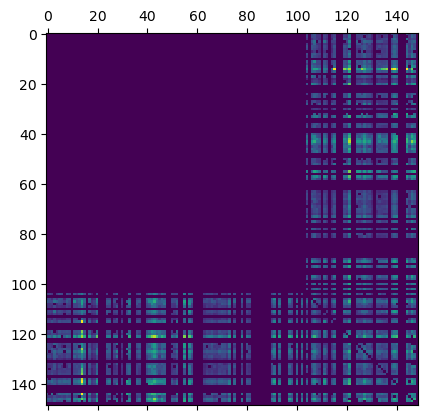

In [35]:
plt.matshow(plot_mat)
plt.clim(0,1) 
# plt.colorbar()
plt.show()

In [36]:
old_stdout = sys.stdout # backup current stdout
sys.stdout = open(os.devnull, "w")

all_results = evaluate_config(config_file="uncertainty_estimate_analysis_ens_20", 
             path_to_conf="/Users/paul/PycharmProjects/NewReservoir/"
                              "Recover/RayLogs/",
             get_eval_loader=get_one_hidden_drug_split_trainval_loader)

sys.stdout = old_stdout # reset old stdout

print("R2", round(all_results['comb_r_squared'].mean(), 3), "\pm", 
      round(all_results['comb_r_squared'].std(),3))
print('spearman', round(all_results['spearman'].mean(), 3), "\pm", 
      round(all_results['spearman'].std(), 3))

  0%|                                                                                                                                                 | 0/5 [00:00<?, ?it/s]/var/folders/k3/yv9hq08j1vvbkzfmhdr7b05w0000gn/T/ipykernel_1338/1880582301.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_results = all_results.append(this_run_df)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.27s/it]

R2 0.338 \pm 0.005
spearman 0.468 \pm 0.009


In [37]:
all_results = all_results.reset_index()

In [38]:
combos = all_results.loc[0]["all_combos"]

In [39]:
predictions = all_results.loc[0]["all_out"]

In [40]:
uncertainties = {tuple(combos[i]): float(predictions.std(dim=1)[i]) for i in range(len(combos))}

In [41]:
for k, v in uncertainties.items():
    plot_mat[true_index_to_plot_index[k[0]], true_index_to_plot_index[k[1]]] = v
    plot_mat[true_index_to_plot_index[k[1]], true_index_to_plot_index[k[0]]] = v

In [42]:
mat_indices_names = {true_index_to_plot_index[v]: k for k, v in data.rec_id_to_idx_dict.items()}

/var/folders/k3/yv9hq08j1vvbkzfmhdr7b05w0000gn/T/ipykernel_1338/3020292888.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(tick_labels)
/var/folders/k3/yv9hq08j1vvbkzfmhdr7b05w0000gn/T/ipykernel_1338/3020292888.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(tick_labels)


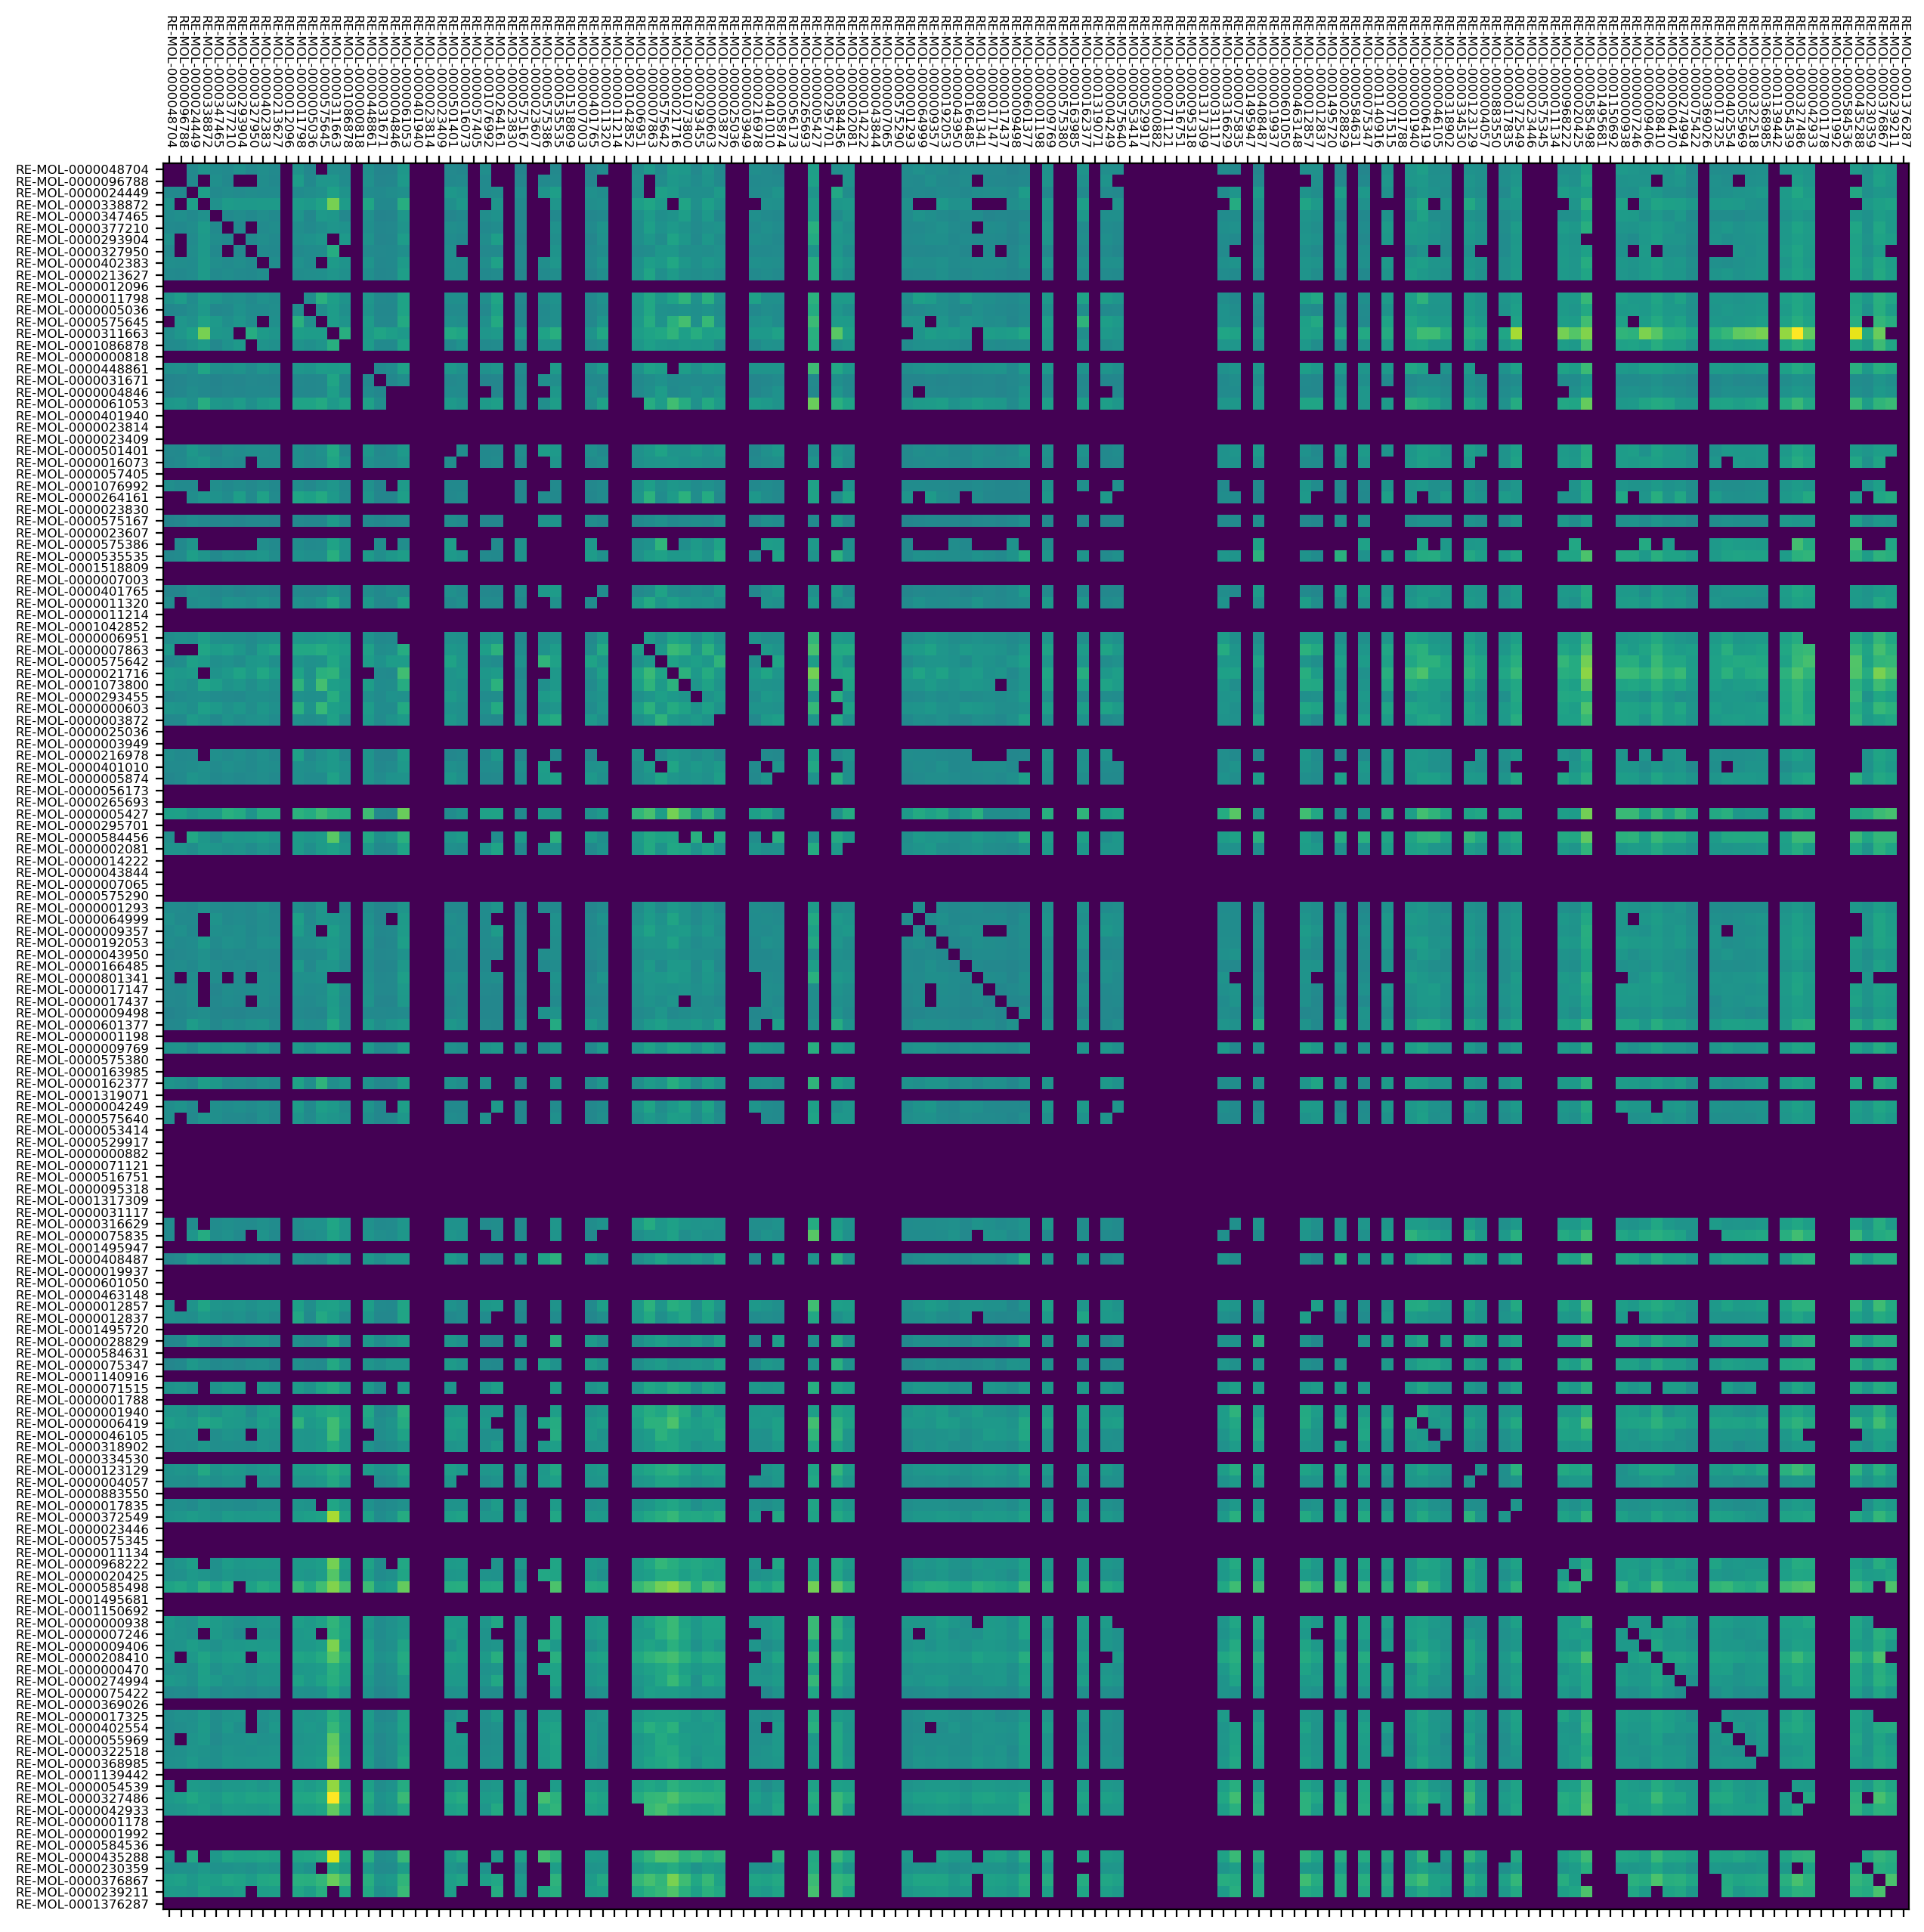

In [43]:
import matplotlib.ticker as mticker

figure = plt.figure(figsize=(20, 15), dpi=200)
axes = figure.add_subplot(111)
axes.matshow(plot_mat)
tick_labels = [mat_indices_names[i] for i in range(len(plot_mat))]
axes.set_xticklabels(tick_labels)
axes.set_yticklabels(tick_labels)

plt.xticks( range(len(plot_mat)), fontsize=6, rotation=270)
plt.yticks( range(len(plot_mat)), fontsize=6)
# ax.clim(0,1) 
# plt.colorbar()
plt.show()

In [44]:
indices_to_keep = []
train_val_indices_to_keep = []
for i in range(len(plot_mat)):
    if not (plot_mat[i] == -1.).all():
        indices_to_keep.append(i)
        if i < len(trainval_drug_idxs):
            train_val_indices_to_keep.append(i)

In [45]:
kept_tick_labels = [tick_labels[i] for i in indices_to_keep]

In [46]:
plot_mat[indices_to_keep][:, indices_to_keep]

array([[-1.        , -1.        ,  0.08953729, ...,  0.15296319,
         0.29586759,  0.24327943],
       [-1.        , -1.        ,  0.084541  , ...,  0.16300222,
         0.31200585,  0.240832  ],
       [ 0.08953729,  0.084541  , -1.        , ...,  0.1553122 ,
         0.21868807,  0.20263638],
       ...,
       [ 0.15296319,  0.16300222,  0.1553122 , ..., -1.        ,
         0.43653384,  0.40057206],
       [ 0.29586759,  0.31200585,  0.21868807, ...,  0.43653384,
        -1.        ,  0.62808192],
       [ 0.24327943,  0.240832  ,  0.20263638, ...,  0.40057206,
         0.62808192, -1.        ]])

In [47]:
drug_name_mapping = pd.read_csv("/Users/paul/PycharmProjects/NewReservoir/Reservoir/reservoir/data/"
                                "parsed/drugs/drug_names.csv").drop_duplicates("recover_id").set_index("recover_id")

RE-MOL-0000311663
RE-MOL-0001086878
RE-MOL-0001076992
RE-MOL-0000021716
RE-MOL-0001073800
RE-MOL-0000000603
RE-MOL-0000192053
RE-MOL-0000166485
RE-MOL-0000801341
RE-MOL-0000017147
RE-MOL-0000017437
RE-MOL-0000020425
RE-MOL-0000208410
RE-MOL-0000000470
RE-MOL-0000274994
RE-MOL-0000075422
RE-MOL-0000017325


/var/folders/k3/yv9hq08j1vvbkzfmhdr7b05w0000gn/T/ipykernel_1338/3984016088.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(kept_tick_label_names)
/var/folders/k3/yv9hq08j1vvbkzfmhdr7b05w0000gn/T/ipykernel_1338/3984016088.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(kept_tick_label_names)


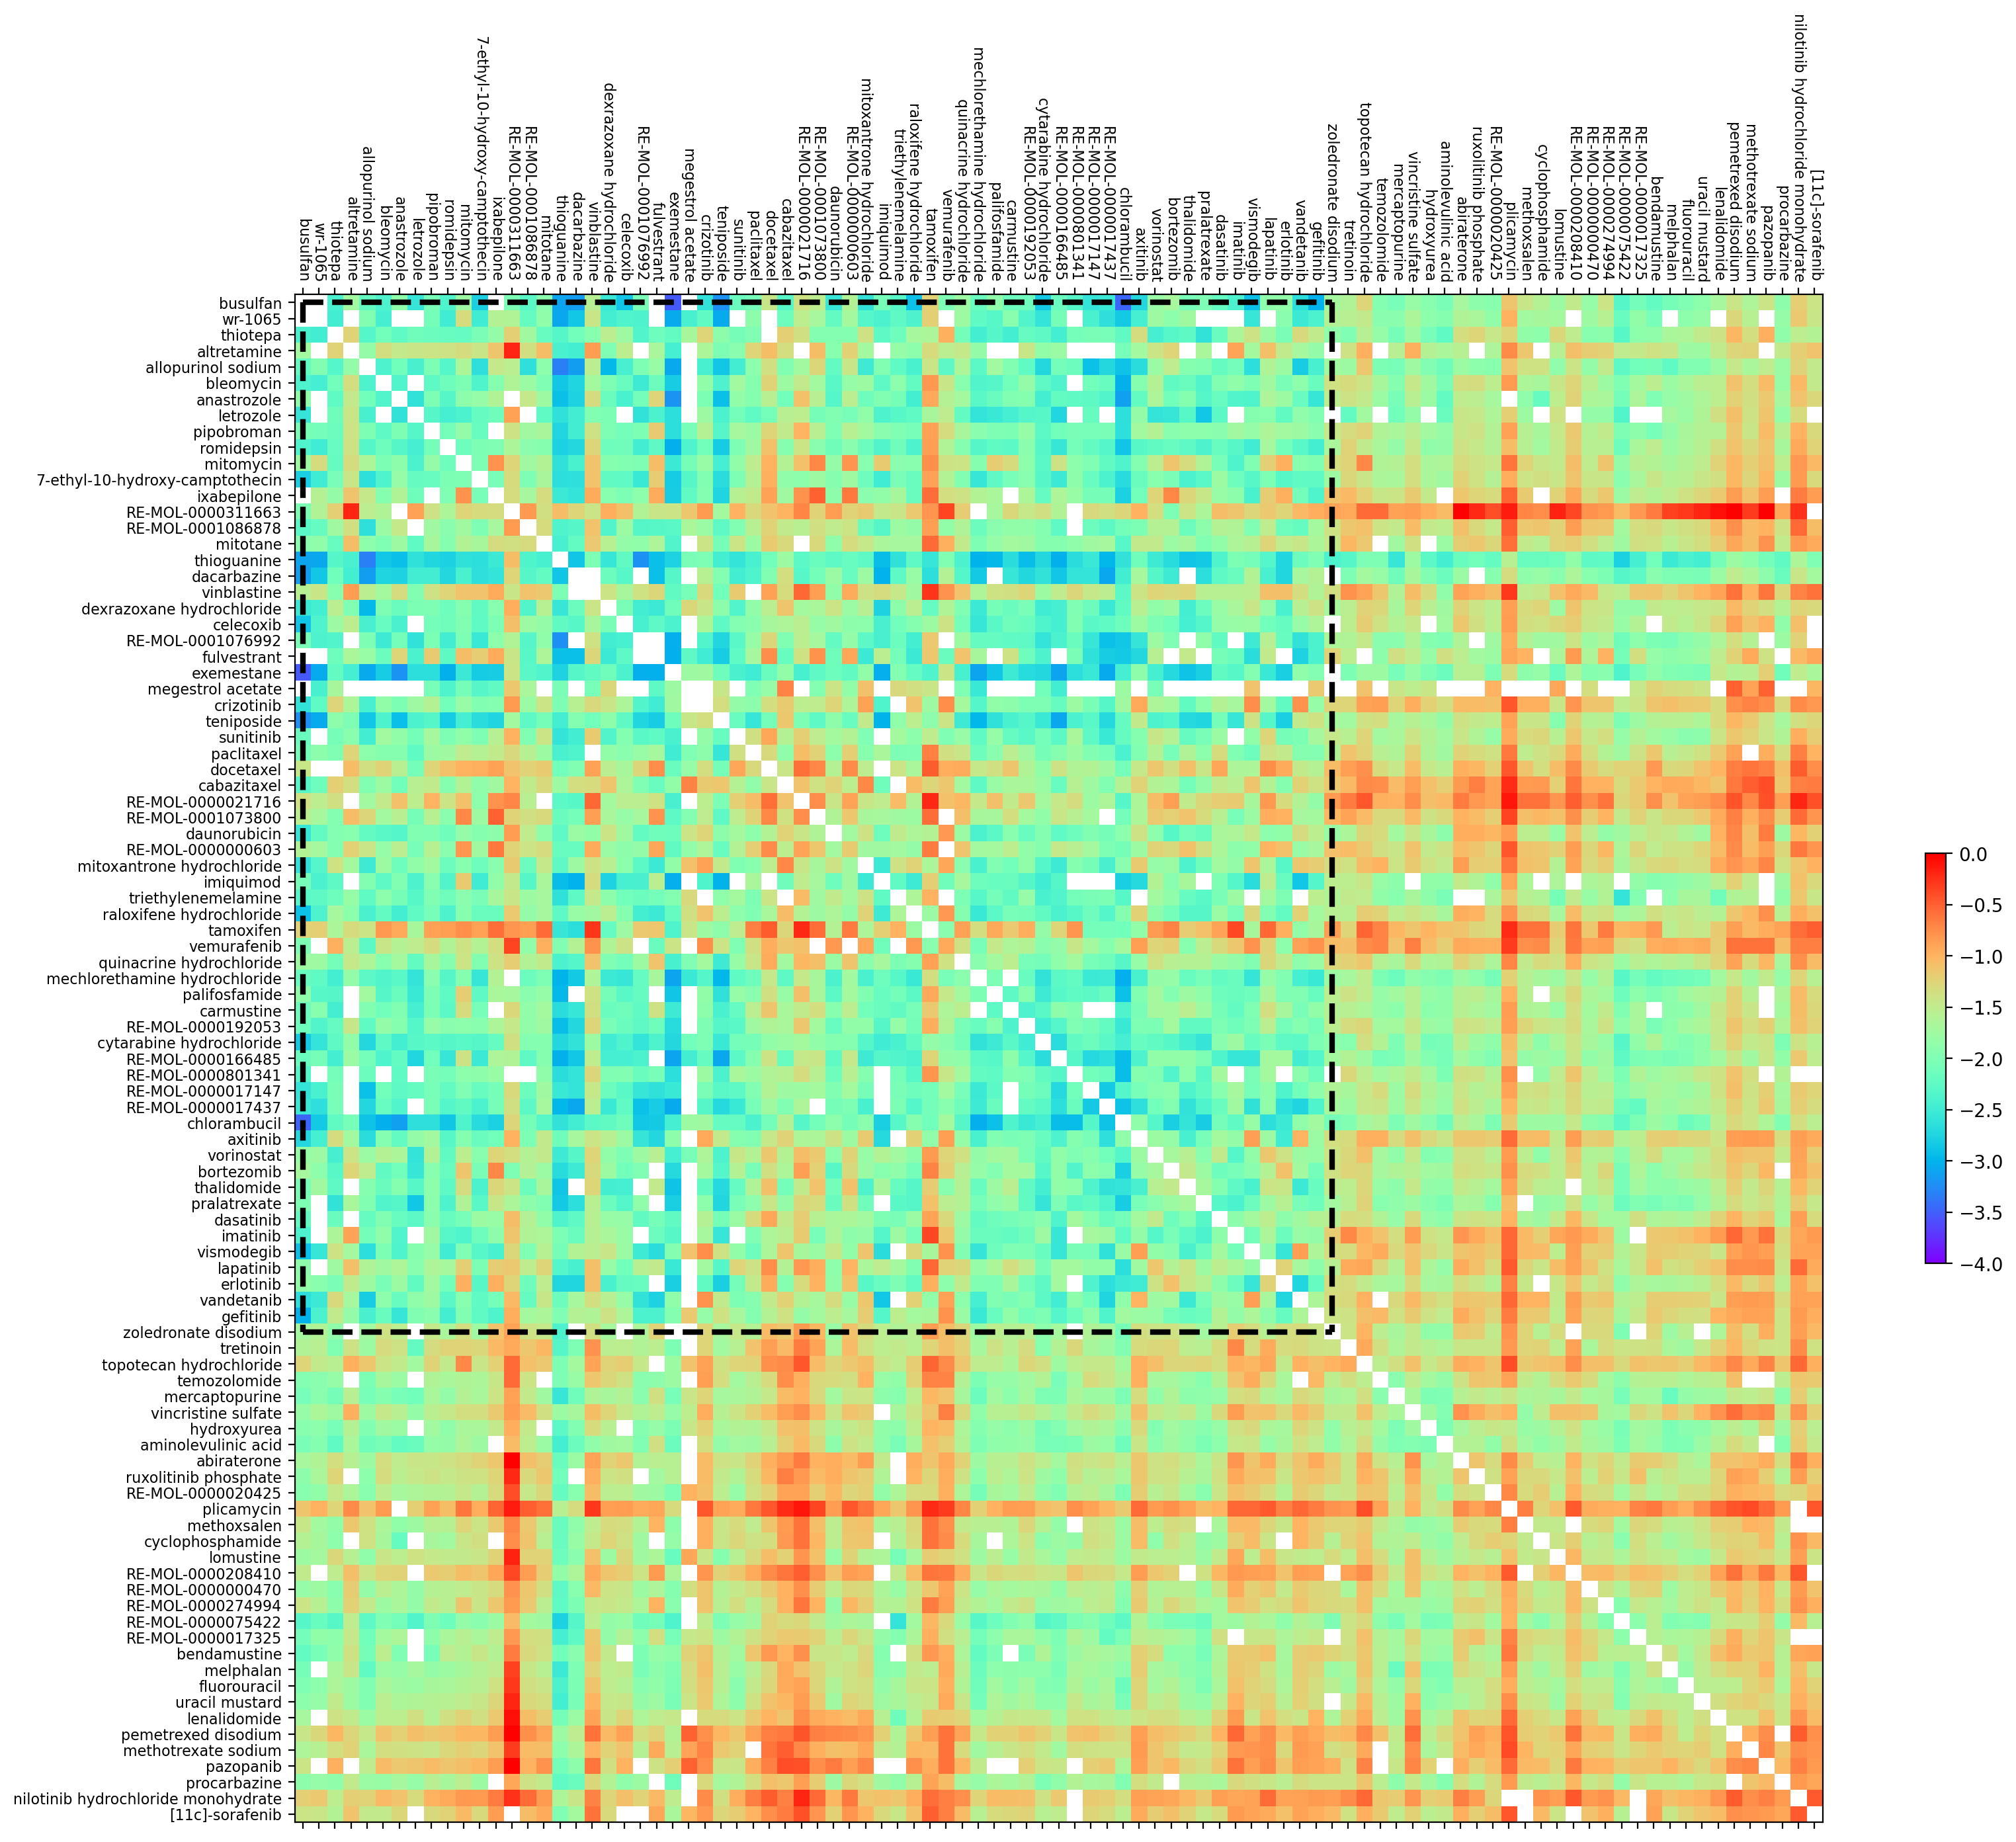

In [87]:
import matplotlib
figure = plt.figure(figsize=(20, 15), dpi=200)
axes = figure.add_subplot(111)
kept_plot_mat = plot_mat[indices_to_keep][:, indices_to_keep]

# Apply log scale
kept_plot_mat[kept_plot_mat != -1] = np.log(kept_plot_mat[kept_plot_mat != -1])
kept_plot_mat[kept_plot_mat == -1] = - 10


my_cmap = matplotlib.cm.get_cmap('rainbow')
my_cmap.set_under('w')
img = axes.matshow(kept_plot_mat, vmin=-4, vmax=0, cmap=my_cmap)
# plt.clim(0,1) 
plt.colorbar(img, ax=axes, fraction=0.01)
kept_tick_label_names = []

for rec_id in kept_tick_labels:
    if rec_id in drug_name_mapping.index:
        kept_tick_label_names.append(drug_name_mapping.loc[rec_id]['name'])
    else:
        print(rec_id)
        kept_tick_label_names.append(rec_id)

axes.set_xticklabels(kept_tick_label_names)
axes.set_yticklabels(kept_tick_label_names)

plt.xticks( range(len(kept_plot_mat)), fontsize=8, rotation=270)
plt.yticks( range(len(kept_plot_mat)), fontsize=8)

n_trainval_drugs_kept = len(train_val_indices_to_keep)

plt.vlines(x=[n_trainval_drugs_kept], ymin=[0], ymax=[n_trainval_drugs_kept], colors='k', ls='--', lw=3)
plt.vlines(x=[0], ymin=[0], ymax=[n_trainval_drugs_kept], colors='k', ls='--', lw=3)
plt.hlines(y=[n_trainval_drugs_kept], xmin=[0], xmax=[n_trainval_drugs_kept], colors='k', ls='--', lw=3)
plt.hlines(y=[0], xmin=[0], xmax=[n_trainval_drugs_kept], colors='k', ls='--', lw=3)

plt.show()

In [49]:
import seaborn as sns

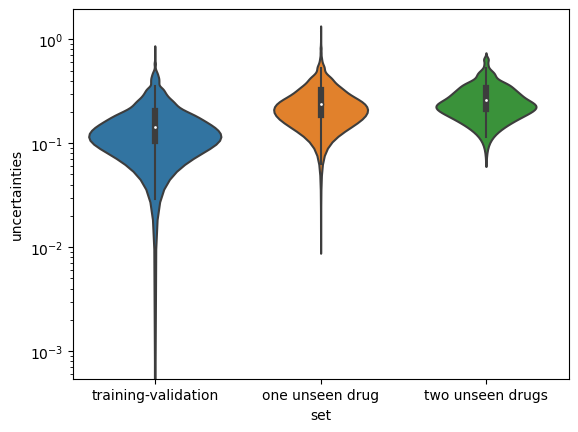

In [50]:
train_kept_plot_mat = kept_plot_mat[:n_trainval_drugs_kept][:, :n_trainval_drugs_kept]
one_hidden_kept_plot_mat = kept_plot_mat[:n_trainval_drugs_kept][:, n_trainval_drugs_kept:]
two_hidden_kept_plot_mat = kept_plot_mat[n_trainval_drugs_kept:][:, n_trainval_drugs_kept:]

df = pd.DataFrame.from_dict({"uncertainties": train_kept_plot_mat[train_kept_plot_mat !=-1], 
 "set": ["training-validation"]*len(train_kept_plot_mat[train_kept_plot_mat !=-1])})

df_2 = pd.DataFrame.from_dict({"uncertainties": one_hidden_kept_plot_mat[one_hidden_kept_plot_mat !=-1], 
 "set": ["one unseen drug"]*len(one_hidden_kept_plot_mat[one_hidden_kept_plot_mat !=-1])})

df_3 = pd.DataFrame.from_dict({"uncertainties": two_hidden_kept_plot_mat[two_hidden_kept_plot_mat !=-1], 
 "set": ["two unseen drugs"]*len(two_hidden_kept_plot_mat[two_hidden_kept_plot_mat !=-1])})

df = pd.concat([df, df_2, df_3])

sns.violinplot(data=df, y="uncertainties", x="set", orient="v")
plt.yscale("log")
plt.show()


# Distance to training set

In [51]:
tanimoto_distances_permuted = np.zeros(tanimoto_distances.shape)
for i in range(len(tanimoto_distances)):
    for j in range(len(tanimoto_distances)):
        tanimoto_distances_permuted[true_index_to_plot_index[i], true_index_to_plot_index[j]] = \
        tanimoto_distances[i, j]

In [52]:
tanimoto_distances_permuted_kept = tanimoto_distances_permuted[indices_to_keep][:, indices_to_keep]

In [53]:
# distances_to_training_set = \
# tanimoto_distances_permuted_kept[n_trainval_drugs_kept:][:, :n_trainval_drugs_kept].min(axis=1)

In [54]:
distances_to_training_set = \
tanimoto_distances_permuted_kept[n_trainval_drugs_kept:][:, :n_trainval_drugs_kept].sum(axis=1)

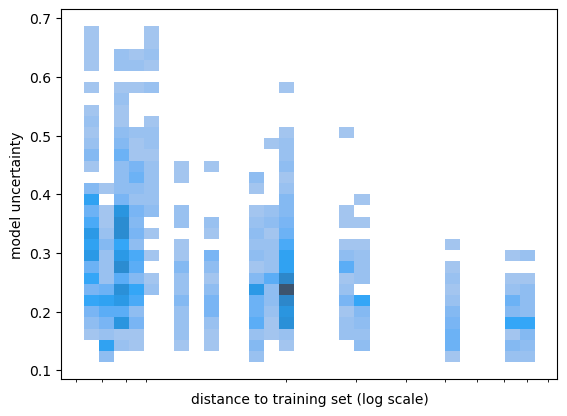

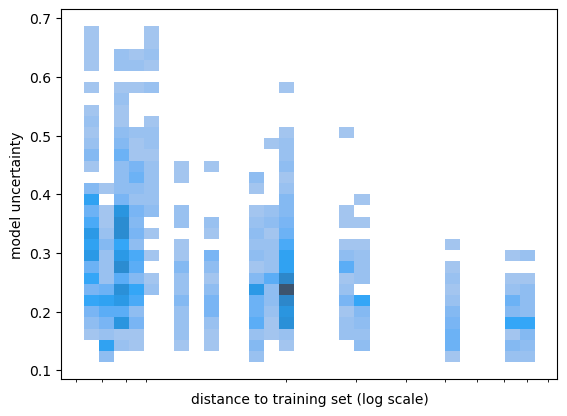

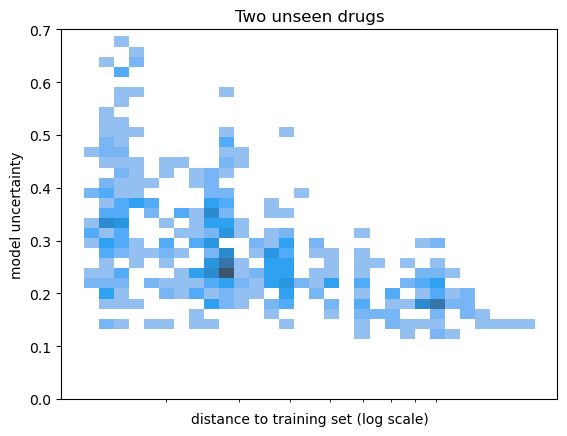

In [115]:
# One hidden
all_distances1 = []
all_distances2 = []
all_uncert = []

for i in range(len(distances_to_training_set)):
    for j in range(len(distances_to_training_set)):
        uncert_i_j = kept_plot_mat[n_trainval_drugs_kept:][:, n_trainval_drugs_kept + i][j]
        if uncert_i_j != -1:
            all_distances1.append(distances_to_training_set[j])
            all_distances2.append(distances_to_training_set[i])
            all_uncert.append(uncert_i_j)
           
        
my_df = pd.DataFrame.from_dict({"distance to training set (1)": all_distances1,
                                "distance to training set (2)": all_distances2,
                                "sum": [all_distances1[i] + all_distances2[i] for i in range(len(all_distances1))],
                       "model uncertainty": all_uncert})

plt.xscale("log")
sns.histplot(
    my_df, x="distance to training set (1)", y="model uncertainty",
    bins=30,# discrete=(True, False), log_scale=(False, True),
)
        
# sns.histplot(all_distances, all_uncert)
plt.xticks([])
plt.xlabel("distance to training set (log scale)")
# plt.ylabel("model uncertainty")
# plt.ylim(0, 0.8)
plt.show()

plt.xscale("log")
sns.histplot(
    my_df, x="distance to training set (2)", y="model uncertainty",
    bins=30,# discrete=(True, False), log_scale=(False, True),
)
        
# sns.histplot(all_distances, all_uncert)
plt.xticks([])
plt.xlabel("distance to training set (log scale)")
# plt.ylabel("model uncertainty")
# plt.ylim(0, 0.8)
plt.show()

plt.xscale("log")
sns.histplot(
    my_df, x="sum", y="model uncertainty",
    bins=30,# discrete=(True, False), log_scale=(False, True),
)
        
# sns.histplot(all_distances, all_uncert)
plt.xticks([])
plt.xlabel("distance to training set (log scale)")
# plt.ylabel("model uncertainty")
plt.ylim(0, 0.7)
plt.title("Two unseen drugs")
plt.show()

In [116]:
my_df.to_csv("two_unseen_drug_distances_and_uncertainty.csv")

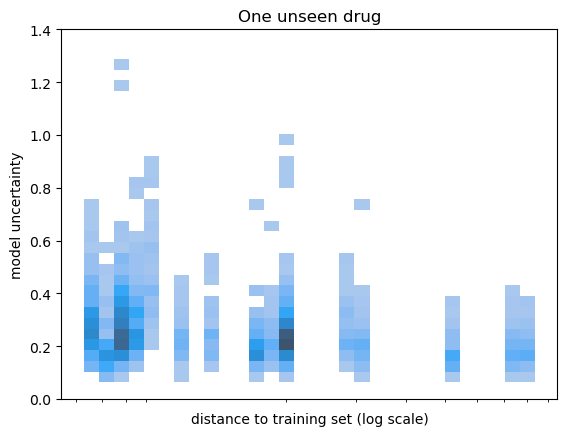

In [111]:
# One hidden
all_distances = []
all_uncert = []

for i in range(n_trainval_drugs_kept):
    for j in range(len(distances_to_training_set)):
        uncert_i_j = kept_plot_mat[n_trainval_drugs_kept:][:, i][j]
        if uncert_i_j != -1:
            all_distances.append(distances_to_training_set[j])
            all_uncert.append(uncert_i_j)
           
        
my_df = pd.DataFrame.from_dict({"distance to training set": all_distances,
                       "model uncertainty": all_uncert})

plt.xscale("log")
sns.histplot(
    my_df, x="distance to training set", y="model uncertainty",
    bins=30,# discrete=(True, False), log_scale=(False, True),
)
        
# sns.histplot(all_distances, all_uncert)
plt.xticks([])
plt.xlabel("distance to training set (log scale)")
# plt.ylabel("model uncertainty")
plt.ylim(0, 1.4)
plt.title("One unseen drug")
plt.show()

In [112]:
my_df.to_csv("one_unseen_drug_distances_and_uncertainty.csv")